## Exploring system log

The purpose of this script is to identify user connections to our system in order to get an overview of the number of users.

Only the logs from September 27 to 30, 2021 were used for the test.

### Import libs

In [1]:
import os 
from os import walk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Exploring log files
Creation of a function to extract the log to a dataframe

In [2]:
# Create a function to extract the log to a dataframe

def system_log_to_df(path,log_name) :
    # Creat df
    df = pd.read_csv(path+log_name, header=None, sep='\t')
    df = df[0].str.extract(('(\S+) ')*13 +('(\S+)'))
    df = df.iloc[4:].reset_index(drop=True)

    # Deal with columns names
    columns_names = ['date', 'time', 's-ip','cs-method','cs-uri-stem','cs-uri-query','s-port','cs-username','c-ip','cs(User-Agent)','sc-status','sc-substatus','sc-win32-status','time-taken']
    new_names = []
    for name in columns_names :
        name = name.lower().replace('-','_').replace('(','_').replace(')','_')
        new_names.append(name)
    df.columns = new_names

    # Deal with datatype
    df['date'] = pd.to_datetime(df['date'])
    df['time'] = pd.to_datetime(df['time'],format= '%H:%M:%S' ).dt.time
    df[['s_port','sc_status','sc_substatus','sc_win32_status','time_taken']] = df[['s_port','sc_status','sc_substatus','sc_win32_status','time_taken']].apply(pd.to_numeric)
    
    # Add log source
    df.insert(0, 'DC','Unknown')
    df.insert(1, 'log_name',log_name)
    if 'DC_1' in path :
        df['DC'] = 'DC_1'
    elif 'DC_2' in path :
        df['DC'] = 'DC_2' 
    else :
        df['DC'] = 'Unknown'        
    
    return df


### Transform Log files to a dataframe
Exctact all the log to a single dataframe named `main_df`

In [3]:
# Current directory
mypath = os.getcwd()

# empty df
main_df = pd.DataFrame()

# Get files names
for (dirpath, dirnames, filenames) in walk(mypath):
    if ('DC_1' in dirpath) or ('DC_2' in dirpath) :
        for log_file in filenames :
            if '.log' in log_file :
                print('Processing : ' + log_file)
                
                # Creat main_df
                df = system_log_to_df(dirpath+'\\',log_file)
                main_df = pd.concat([df, main_df])

                    
main_df = main_df.sort_values(['date', 'time'],ascending = False).reset_index(drop=True)     
print('End of processing')
print(main_df.shape)

Processing : log_210927.log
Processing : log_210928.log
Processing : log_210929.log
Processing : log_210930.log
Processing : log_211001.log
Processing : log_211002.log
Processing : log_211003.log
Processing : log_211004.log
Processing : log_210927.log
Processing : log_210928.log
Processing : log_210929.log
Processing : log_210930.log
End of processing
(542307, 16)


#### Filter the df on common log date of DC_1 and DC_2
For the purpose of this test, only the common dates between DC_1 and DC_2 will be kept.

In [4]:
main_df = main_df[(main_df['date'] >= '2021-09-27') & (main_df['date'] <= '2021-09-30')]
main_df.shape

(409260, 16)

### Get number of connexion by day
Attention, there is no possibility to identify unique connexion at this point with the current log. A demand is made to provide unique ID per user or to identify unique WKS. So the connexion numbers show below can come from a same user.

#### Filtering df to identify connexion logs
We will filter on 'signin' prefix from `cs_uri_stem` and 'POST' from `cs_method`

In [5]:
# Get the sign in structure in the logs
sign_in = main_df[main_df['cs_uri_stem']=='/IdentityServer/account/signin']
sign_in = sign_in[sign_in['cs_method']=='POST']
print(sign_in.shape)

(1640, 16)


##### Explore others columns to identify a filtering option 
We will try to find othe column to filter the signin 

In [6]:
# HTTP status
sign_in['sc_status'].value_counts()
# 200 = succed
# 302 = redirection

302    1628
200      12
Name: sc_status, dtype: int64

In [7]:
sign_in['sc_substatus'].value_counts() #Column could be dropped

0    1640
Name: sc_substatus, dtype: int64

In [8]:
sign_in['sc_win32_status'].value_counts() #Column could be dropped

0    1640
Name: sc_win32_status, dtype: int64

In [9]:
sign_in['s_port'].value_counts() #Column could be dropped

80    1640
Name: s_port, dtype: int64

None of `sc_status` `sc_substatus` `sc_win32_status` `s_port` `c_ip` columns will be used for the rest of the procedure. 

#### Exploration of deviced on which system is used
Exploration of `cs_user_agent_` column to identify the devices on which the system is used. 

In [10]:
# Set user friendly name to devices
device_map_dic = {
    # From https://developer.mozilla.org/en-US/docs/Web/HTTP/Headers/User-Agent/Firefox
    'Mozilla/5.0+(Windows+NT+6.1;+Win64;+x64;+rv:78.0)+Gecko/20100101+Firefox/78.0':'Firefox 78.0',
    'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64;+rv:92.0)+Gecko/20100101+Firefox/92.0':'Firefox 92.0',
    'Mozilla/5.0+(Windows+NT+6.3;+Win64;+x64;+Trident/7.0;+rv:11.0)+like+Gecko':'IE 11.0 (?)',
    'Mozilla/5.0+(Windows+NT+6.1;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/75.0.3770.100+Safari/537.36':'Android WebView',
}
sign_in['device'] = sign_in['cs_user_agent_'].map(device_map_dic)

In [11]:
# Assign color by category for further graph
colors = {'Firefox 92.0':'tab:blue', 
          'Firefox 78.0':'tab:orange', 
          'Android WebView':'tab:green', 
          'IE 11.0 (?)':'tab:red'}

labels = sign_in['device'].unique()

IE 11.0 (?)        1536
Firefox 78.0         85
Firefox 92.0         13
Android WebView       6
Name: device, dtype: int64


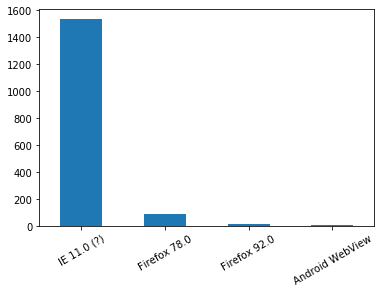

In [12]:
# Get an overview 
device_count = sign_in['device'].value_counts()
print(device_count)

# Plot
device_count.plot(kind='bar')
plt.xticks(rotation=30)
plt.show()


We see that IE11 is heavily used. That doesn't match with users normal browser usage. Default browser are Firefox v78 or v92 or Android. IE11 connexion might come from a server. Need to be clarified.

For further investigation IE11 connexion will be ignored.

#### Drop IE11 entries from the dataframe

In [13]:
# Drop IE11
print(sign_in.shape)
sign_in = sign_in[sign_in['device'] !='IE 11.0 (?)']
print(sign_in.shape)

# Get an overview 
device_count = sign_in['device'].value_counts()
print(device_count)

(1640, 17)
(104, 17)
Firefox 78.0       85
Firefox 92.0       13
Android WebView     6
Name: device, dtype: int64


This data seems much more realistic compared to the estimated usage that we have.

### Plot the graph of the identified log connexions
We will be able to visualize the connection information.

            nb_connexion
date                    
2021-09-27            18
2021-09-28            25
2021-09-29            32
2021-09-30            29

Mean of non unique connexion : 26.0/day


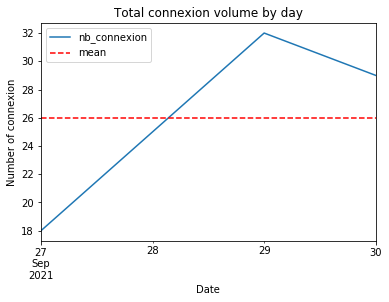

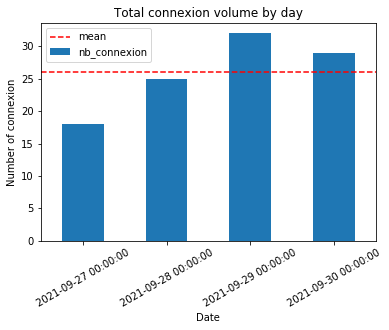

In [14]:
# Create a pivot table per day
sign_in_by_day = sign_in.pivot_table(values='cs_uri_stem', index=['date'], aggfunc='count')
sign_in_by_day.columns = ['nb_connexion']
print(sign_in_by_day)

# get mean value
sign_in_mean_by_day = sign_in_by_day['nb_connexion'].mean()
print("\nMean of non unique connexion : " + str(sign_in_mean_by_day) + '/day')

# Plot line chart
sign_in_by_day.plot()
plt.title('Total connexion volume by day')
plt.ylabel('Number of connexion')
plt.xlabel('Date')
plt.axhline(y=sign_in_mean_by_day, color='r', linestyle='--', label = 'mean')
plt.legend()
plt.show()

# Plot bar chart
sign_in_by_day.plot(kind='bar')
plt.title('Total connexion volume by day')
plt.ylabel('Number of connexion')
plt.xlabel('Date')
plt.xticks(rotation=30)
plt.axhline(y=sign_in_mean_by_day, color='r', linestyle='--', label = 'mean')
plt.legend()
plt.show()

### Connexion by Data Center
#### DC connexion volume by day
Vizualise connexion to DC_1 and DC_2 over time

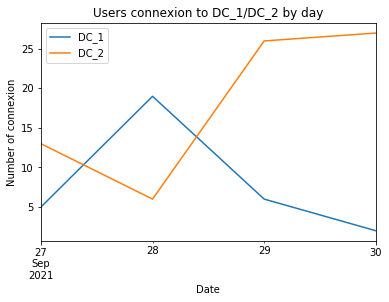

In [15]:
# Set pivot table
sign_in_by_day_dc = sign_in.pivot_table(values='cs_uri_stem', index=['date','DC'], aggfunc='count')
sign_in_by_day_dc.columns = ['nb_connexion']
sign_in_by_day_dc.reset_index(level=1, inplace=True)

# Plot
sign_in_by_day_dc.groupby('DC')['nb_connexion'].plot(legend=True)
plt.title('Users connexion to DC_1/DC_2 by day')
plt.ylabel('Number of connexion')
plt.xlabel('Date')
plt.show()

#### Connexion volume aggregation by DC


Mean of non unique connexion fo DC : 52.0


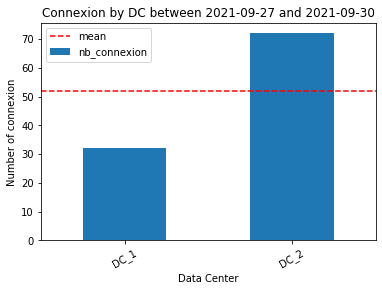

In [16]:
# Aggregate
group_by_dc = sign_in_by_day_dc.groupby('DC').agg('sum')

mean_dc = group_by_dc['nb_connexion'].mean()
print("\nMean of non unique connexion for DC : " + str(mean_dc))

# Plot
group_by_dc.plot(kind='bar')
plt.title('Connexion by DC between {} and {}'.format(
        min(sign_in['date'].dt.date),
        max(sign_in['date'].dt.date)
        ))
plt.ylabel('Number of connexion')
plt.xlabel('Data Center')
plt.xticks(rotation=30)
plt.axhline(y=mean_dc, color='r', linestyle='--', label = 'mean')
plt.legend()
plt.show()

### Connexion by Device
#### Device connexion volume by day

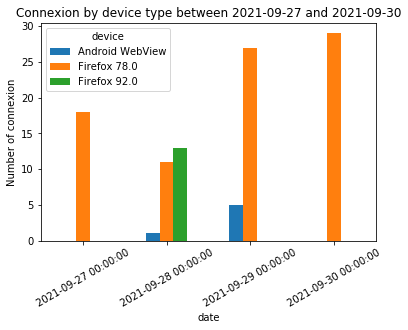

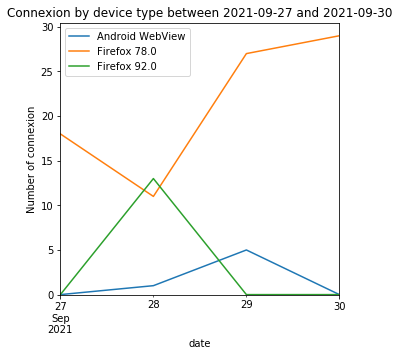

In [17]:
# Group by device
sign_in_by_device = sign_in.groupby('date')['device'].value_counts()
sign_in_by_device = sign_in_by_device.unstack().fillna(0)
# Plot
sign_in_by_device.plot.bar(rot=30)
plt.title('Connexion by device type between {} and {}'.format(
        min(sign_in['date'].dt.date),
        max(sign_in['date'].dt.date)
        ))
plt.ylabel('Number of connexion')
plt.show()

# Plot line
fig, ax = plt.subplots(figsize=(5, 5))
for column in sign_in_by_device.columns :
    label = column
    grp = sign_in_by_device[column]
    grp.plot(label = label, legend = True )

plt.title('Connexion by device type between {} and {}'.format(
        min(sign_in['date'].dt.date),
        max(sign_in['date'].dt.date)
        ))
axes = plt.gca()
axes.set_ylim(0)
plt.ylabel('Number of connexion')    
plt.show()

#### Connexion volume aggregation by device

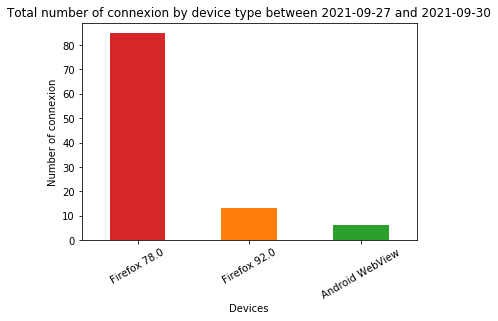

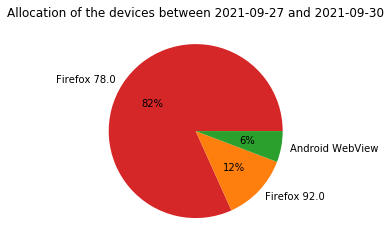

In [18]:
# Plot result in bar
device_count.plot(kind='bar',
                  color=[colors[key] for key in labels])
plt.title('Total number of connexion by device type between {} and {}'.format(
        min(sign_in['date'].dt.date),
        max(sign_in['date'].dt.date)
        ))
plt.ylabel('Number of connexion')
plt.xlabel('Devices')
plt.xticks(rotation=30)
plt.show()

# Plot result in pie (%)
device_count_norm =  sign_in['device'].value_counts(normalize=True)
device_count_norm.plot(kind='pie',
                       autopct='%1.0f%%',
                       colors=[colors[key] for key in labels],
                       title='Allocation of the devices between {} and {}'.format(
        min(sign_in['date'].dt.date),
        max(sign_in['date'].dt.date)
        ))
plt.ylabel('')
plt.show()

# Conclusion

A connexion line is :

|     Colonnes           |     Valeurs   à inclure                                                                                                                                                                                                                                                                                                                                       |
|------------------------|---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
|     'cs_method'        |     'POST'                                                                                                                                                                                                                                                                                                                                                    |
|     'cs_uri_stem'      |     '/IdentityServer/account/signin'                                                                                                                                                                                                                                                                                                                |
|     'cs_user_agent'    |     'Mozilla/5.0+(Windows+NT+6.1;+Win64;+x64;+rv:78.0)+Gecko/20100101+Firefox/78.0':'Firefox   78.0',     'Mozilla/5.0+(Windows+NT+10.0;+Win64;+x64;+rv:92.0)+Gecko/20100101+Firefox/92.0':'Firefox   92.0',     'Mozilla/5.0+(Windows+NT+6.1;+Win64;+x64)+AppleWebKit/537.36+(KHTML,+like+Gecko)+Chrome/75.0.3770.100+Safari/537.36':'Android   WebView',    |